In [2]:
%reload_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
%matplotlib inline

import os 
import io
import math
from datetime import datetime 
import shapely.geometry
import json
from pathlib import Path
import pathlib

import IPython.display
from IPython.display import display
from ipywidgets import GridspecLayout
import ipywidgets as widgets

from xcube_sh.cube import open_cube
from xcube_sh.observers import Observers

from src.GIS_utils import bbox_from_point
from src.config import CubeConfig
from src.preprocess import preprocess, plot_cube_and_background, save_labels, save_cubes


import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

import superintendent

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [3]:
def request_save_cubes(start_date, end_date, lat, lon, RADIUS = 500, 
               dataset_name='S2L1C', band_names=['B03', 'B08', 'CLP'], 
               max_cloud_proba=0.1, time_period='1D'):
    
    bbox = bbox_from_point(lat=lat, lon=lon, r=RADIUS)
    cube_config = CubeConfig(dataset_name=dataset_name,
                             band_names=band_names, # GREEN + NIR + Clouds
                             tile_size=[2*RADIUS//10, 2*RADIUS//10],
                             geometry=bbox,
                             time_range=[start_date, end_date],
                             time_period=time_period,
                            )
    request_collector = Observers.request_collector()
    cube = open_cube(cube_config, observer=request_collector)

    cube, background_ndwi = preprocess(cube, max_cloud_proba=max_cloud_proba, 
                                       nans_how='any', verbose=1, plot_NDWI=False)
    save_cubes(cube, background_ndwi, lat_lon=(lat,lon), data_dir=Path(data_chips_dir), verbose=False)


In [4]:
aoi_json_filepath = "data/aoi.json"
data_chips_dir = "/home/jovyan/data/chips/"

start_date_2019 = '2019-01-01'
end_date_2019 = '2019-06-30'

start_date_2020 = '2020-01-01'
end_date_2020 = '2020-06-30'

### request and download images

In [23]:
with open(aoi_json_filepath, "r") as f: 
    aoi_file = json.load(f)
    straits_dict = aoi_file['Straits']
    for aoi_name, aoi_locs in straits_dict.items():
        for loc in aoi_locs:
            lat, lon = loc[0], loc[1]
            subdir = 'lat_{}_lon_{}'.format(str(lat).replace('.','_'), str(lon).replace('.','_'))
            # 2019 
            if not Path(data_chips_dir, subdir).exists() or len(list(Path(data_chips_dir, subdir).glob("*2019*.png"))) == 0:
                print(f"aoi name: {aoi_name}, subdir {subdir}, download 2019 images")
                request_save_cubes(start_date_2019, end_date_2019, lat, lon)
            # 2020
            if not Path(data_chips_dir, subdir).exists() or len(list(Path(data_chips_dir, subdir).glob("*2020*.png"))) == 0:
                print(f"aoi name: {aoi_name}, subdir {subdir}, download 2020 images")
                request_save_cubes(start_date_2020, end_date_2020, lat, lon)    

aoi name: Rottendam, subdir lat_51_969_lon_4_116, download 2019 images
Keeping 71/181 images without nans
Keeping 25/181 images 90.0% cloudless
aoi name: Rottendam, subdir lat_51_969_lon_4_116, download 2020 images
Keeping 58/182 images without nans
Keeping 20/182 images 90.0% cloudless


### extract images to be labeled

In [24]:
stratis_images = []
with open(aoi_json_filepath, "r") as f: 
    aoi_file = json.load(f)
    straits_dict = aoi_file['Straits']
    for aoi_name, aoi_locs in straits_dict.items():
        for loc in aoi_locs:
            lat, lon = loc[0], loc[1]
            subdir = 'lat_{}_lon_{}'.format(str(lat).replace('.','_'), str(lon).replace('.','_'))
            if Path(data_chips_dir, subdir).exists():
                stratis_images.extend(Path(data_chips_dir, subdir).glob("img_ndwi*.png"))
len(stratis_images), stratis_images[0]

(1510,
 PosixPath('/home/jovyan/data/chips/lat_36_02_lon_-5_36/img_ndwi_t_2019-05-02.png'))

In [25]:
csv_file_path = "/home/jovyan/data/straits_labels.csv"
labels_df = pd.read_csv(csv_file_path, index_col="file_path")
len(labels_df)

1465

In [26]:
tobe_labeled_images = []
for dir_ in stratis_images:
     if str(dir_) not in labels_df.index or pd.isnull(labels_df.loc[str(dir_), "count"]):
        tobe_labeled_images.append(dir_)

In [27]:
len(tobe_labeled_images)

45

In [28]:
# images = [f for f in pathlib.Path("/home/jovyan/data/chips").glob("*/img_ndwi*.png") if f.is_file()]
images = tobe_labeled_images
print(len(images))

def change_colormap(image_path:pathlib.Path, cmap='RdYlBu'):
    feature = imread(image_path)
    cm = plt.get_cmap(cmap)
    colored_image = cm(-feature)
    colored_feature = Image.fromarray(np.uint8(colored_image * 255))
    imgByteArr = io.BytesIO()
    colored_feature.save(imgByteArr, format='PNG')
    imgByteArr = imgByteArr.getvalue()
    return imgByteArr
    
def display_image_and_references(image_path):
    image_folder = image_path.parent
    print(image_folder)
    
    other_images = [
        f for f in image_folder.glob("img_ndwi*.png")
        if f.is_file() and f != image_path
    ]
    other_images.extend(image_folder.glob("bg_ndwi*.png"))
   
    n_col = 4
    n_row = max(math.ceil(len(other_images) / n_col), 1)
    grid = GridspecLayout(n_row, n_col)
    
    for i in range(n_row):
        for j in range(n_col):
            img_index = i * n_col + j
            if img_index >= len(other_images): break
            image = other_images[img_index]
            grid[i, j] = widgets.VBox([
                    widgets.Label(f"Image {image.name}"),
                    widgets.Image(value=change_colormap(image), 
                             layout=widgets.Layout(width='200px', height='200px')),
                ])
    
    image_display = widgets.VBox([
        widgets.VBox([
            widgets.Label(f"folder: {image_folder}"),
            widgets.Label(f"all other images of the same loc"),
            grid,
            widgets.Label(f"image to label: {image_path.name}"),
            widgets.Image(value=change_colormap(image_path), object_fit='none', 
                          layout=widgets.Layout(width='300px', height='300px'))
        ]),
        
    ])
    display(image_display)

labeller = superintendent.ClassLabeller(
    features=images,
    options=[i for i in range(-1, 6)],
    display_func=display_image_and_references,
)

labeller

45


ClassLabeller(children=(HBox(children=(FloatProgress(value=0.0, description='Progress:', max=1.0),)), Box(chil…

In [29]:
tobe_labeled_images
labeller.new_labels
print(len(tobe_labeled_images))

45


In [30]:
for i in range(len(tobe_labeled_images)):
    labels_df.at[str(tobe_labeled_images[i])] = labeller.new_labels[i]

In [31]:
len(labels_df)

1510

In [32]:
labels_df = labels_df[labels_df["count"].notnull()]

In [33]:
len(labels_df)

1510

In [36]:
labels_df['count'] = labels_df['count'].astype(float)

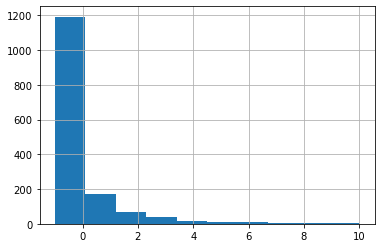

In [37]:
labels_df['count'].hist()

In [38]:
# see how imbalance of the data is
len(labels_df[labels_df['count'] > 0])/len(labels_df)

0.2099337748344371

In [39]:
csv_file_path = "/home/jovyan/data/straits_labels.csv"
labels_df.to_csv(csv_file_path)